# LOCALIZATION

In [ ]:
import os
import requests
from tqdm import tqdm
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.optimizers import Adam



In [ ]:
print("####### LOCALIZATION")

# 数据下载函数
def download_data():
    url = "https://github.com/JJAlmagro/subcellular_localization/raw/refs/heads/master/notebook%20tutorial/data/reduced_train.npz"
    datasetFolderPath = "dataset/"
    file = "reduced_train.npz"
    FilePath = os.path.join(datasetFolderPath, file)

    if not os.path.exists(datasetFolderPath):
        os.makedirs(datasetFolderPath)

    def download_file(url, filename):
        response = requests.get(url, stream=True)
        with tqdm.wrapattr(open(filename, "wb"), "write", miniters=1,
                           total=int(response.headers.get('content-length', 0)),
                           desc=filename) as fout:
            for chunk in response.iter_content(chunk_size=4096):
                fout.write(chunk)

    if not os.path.exists(FilePath):
        download_file(url, FilePath)

# 下载数据
download_data()

####### LOCALIZATION


In [ ]:
# 加载数据
file_data_train = "dataset/reduced_train.npz"
train = np.load(file_data_train)
X_train = train["X_train"]  # (2423, 400, 20)
Y_train = train["y_train"]  # (2423,)
mask_train = train["mask_train"]  # (2423, 400)

# 输出数据集形状
print("Shape of dataset X:", X_train.shape)
print("Shape of dataset Y:", Y_train.shape)
print("Shape of dataset Mask:", mask_train.shape)

# 将标签编码为one-hot
label_encoder = LabelEncoder()
Y_train_encoded = label_encoder.fit_transform(Y_train)
onehot_Y_train = to_categorical(Y_train_encoded)

# 数据统计信息
df = pd.DataFrame(X_train[:, :, 0])  # 分析第一个特征
stats = df.describe()
print("Stats for first feature:\n", stats)

Shape of dataset X: (2423, 400, 20)
Shape of dataset Y: (2423,)
Shape of dataset Mask: (2423, 400)
Stats for first feature:
                0            1            2            3            4    \
count  2423.000000  2423.000000  2423.000000  2423.000000  2423.000000   
mean      0.021865     0.205510     0.099270     0.075233     0.088902   
std       0.114765     0.298014     0.175479     0.142319     0.156582   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.050000     0.020000     0.020000     0.030000   
75%       0.000000     0.300000     0.120000     0.090000     0.100000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

               5            6            7            8            9    ...  \
count  2423.000000  2423.000000  2423.000000  2423.000000  2423.000000  ...   
mean      0.085184     0.093553     0.089930     0

In [ ]:
import tensorflow as tf
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, Add, Input, BatchNormalization, Activation
from keras.models import Model
from keras.optimizers import Adam
from keras.regularizers import l2

# Residual block definition (no mask output, only for classification task)
def residual_block(x, filters, kernel_size=3, stride=1, l2_reg=0.001, dropout_rate=0.3):
    shortcut = x  # Save the input as shortcut for the residual connection

    # First convolutional layer + L2 regularization
    x = Conv1D(filters, kernel_size=kernel_size, strides=stride, padding='same', kernel_regularizer=l2(l2_reg))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Dropout to prevent overfitting
    x = Dropout(dropout_rate)(x)

    # Second convolutional layer + L2 regularization
    x = Conv1D(filters, kernel_size=kernel_size, strides=1, padding='same', kernel_regularizer=l2(l2_reg))(x)
    x = BatchNormalization()(x)

    # Adjust the shortcut shape if the input and output dimensions differ
    if shortcut.shape[-1] != x.shape[-1]:
        shortcut = Conv1D(filters, kernel_size=1, strides=stride, padding='same', kernel_regularizer=l2(l2_reg))(shortcut)

    # Add the shortcut (input) to the output to form the residual connection
    x = Add()([x, shortcut])
    x = Activation('relu')(x)

    return x

# Build 1D ResNet model (without mask output)
def build_resnet_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Initial convolutional layer
    x = Conv1D(filters=64, kernel_size=7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(pool_size=3, strides=2, padding='same')(x)  # Max pooling to reduce spatial dimensions

    # Stack multiple residual blocks
    x = residual_block(x, filters=64)
    x = residual_block(x, filters=64)

    x = residual_block(x, filters=64)
    x = residual_block(x, filters=64)

    # Flatten the output and add a fully connected layer
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.4)(x)

    # Output layer: classification output with softmax activation
    output_class = Dense(num_classes, activation='softmax', name='class_output')(x)

    # Build the model (no mask output, only classification)
    model = Model(inputs=inputs, outputs=output_class)

    # Compile the model (only for classification task)
    model.compile(
        optimizer=Adam(),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Set the input shape and the number of classes
input_shape = (400, 20)  # 400 time steps, 20 features per time step
num_classes = onehot_Y_train.shape[1]

# Build the ResNet model
model = build_resnet_model(input_shape, num_classes)

# Print the model summary
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 400, 20)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_18 (Conv1D)        │ (None, 200, 64)        │          9,024 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_18    │ (None, 200, 64)        │            256 │ conv1d_18[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_18             │ (None, 200, 64)        │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_2           │ (None, 100, 64)        │              0 │ activation_18[0][0]    │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_19 (Conv1D)        │ (None, 100, 64)        │         12,352 │ max_pooling1d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_19    │ (None, 100, 64)        │            256 │ conv1d_19[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_19             │ (None, 100, 64)        │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_10 (Dropout)      │ (None, 100, 64)        │              0 │ activation_19[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_20 (Conv1D)        │ (None, 100, 64)        │         12,352 │ dropout_10[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_20    │ (None, 100, 64)        │            256 │ conv1d_20[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_8 (Add)               │ (None, 100, 64)        │              0 │ batch_normalization_2… │
│                           │                        │                │ max_pooling1d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_20             │ (None, 100, 64)        │              0 │ add_8[0][0]            │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_21 (Conv1D)        │ (None, 100, 64)        │         12,352 │ activation_20[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_21    │ (None, 100, 64)        │            256 │ conv1d_21[0][0]        │
│ (BatchNormalization) 

 Total params: 1,751,370 (6.68 MB)

 Trainable params: 1,750,218 (6.68 MB)

 Non-trainable params: 1,152 (4.50 KB)

In [ ]:
from keras.callbacks import EarlyStopping

# Define EarlyStopping callback: Stop training when validation loss stops improving for 5 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fit the model without mask output, using only the class labels for training
history = model.fit(X_train,
              onehot_Y_train,
              epochs=50,
              batch_size=32,
              validation_split=0.2,
              callbacks=[early_stopping])




Epoch 1/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 19s 155ms/step - accuracy: 0.2223 - loss: 7.6417 - val_accuracy: 0.1443 - val_loss: 2.7437
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 120ms/step - accuracy: 0.3314 - loss: 2.4002 - val_accuracy: 0.2309 - val_loss: 2.6143
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 0.3887 - loss: 2.2094 - val_accuracy: 0.1485 - val_loss: 2.6502
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - accuracy: 0.4445 - loss: 1.9683 - val_accuracy: 0.1505 - val_loss: 2.6232
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 120ms/step - accuracy: 0.4556 - loss: 1.8887 - val_accuracy: 0.2041 - val_loss: 2.5915
Epoch 6/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 122ms/step - accuracy: 0.5148 - loss: 1.7232 - val_accuracy: 0.2474 - val_loss: 2.6673
Epoch 7/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - accuracy: 0.5625 - loss: 1.5788 - val_accuracy: 0.3093 - val_loss: 2.5125
Epoch 8/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 0.5983 - loss: 1.4575 - val_accurac

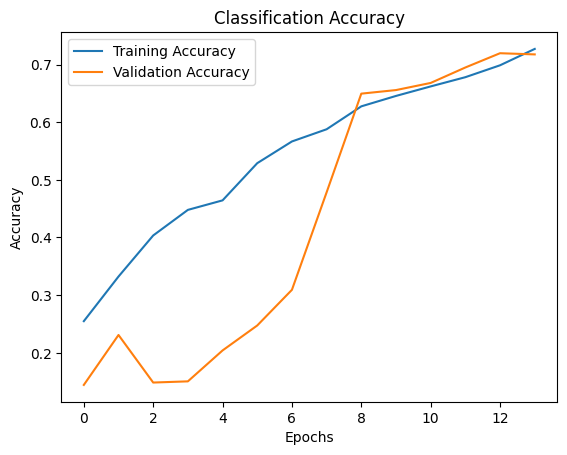

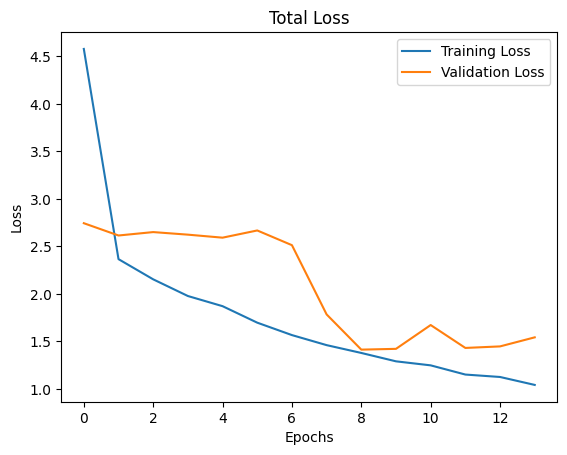

In [ ]:
import matplotlib.pyplot as plt

# Plotting training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')  # Update to use 'accuracy'
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')  # Update to use 'val_accuracy'
plt.title('Classification Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting training and validation losses
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Total Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
